# LOSC Data Quickview

Welcome! This IPython notebook provides a quick look at short segments of data from the <a href='https://losc.ligo.org/'>LIGO Open Science Center</a>

* Set the GPS time (t0) and data set in the first cell
* Click "Run All" in the cell menu at the top
* Your plots will appear at the <a href='#PSD,-Whitened-Data,-and-Spectrogram'>bottom of the page</a>.

v0.4; November 2016

## Set GPS time and data set
Example GPS times for <a href='https://losc.ligo.org/s6hwcbc/'>S6 Hardware Injections</a>

In [16]:
t0 = 1187008064 # Time of big dog (S6 blind injection)
# t0 = 933661015.0  # Time of a successful s6 hardware injection in H1 (SNR 140)

dataset = 'S6'
detector = 'L1'
version = 'V1'  # V1 is "version 1" of the data release


## Download the data file
See also <a href='https://losc.ligo.org/tutorial_get_data2/'>this download tutorial.</a>

In [3]:
import json
from urllib.request import urlopen

'''
observatory = detector[0]         # first letter of the detector H or L
hour        = int(t0)&0xFFFFF000  # the filename rounding down to a multiple of 4096
fortnight   = int(t0)&0xFFF00000  # the directory by rounding down to multiple of 4096*256
filename = '{0}-{1}_LOSC_4_{2}-{3}-2048.hdf5'.format(observatory, detector, version, hour)
urlformat = 'https://losc.ligo.org/archive/data/{0}/{1}/{2}'
url = urlformat.format(dataset, fortnight, filename)
'''
# -- Uncomment these 3 lines to run this notebook on GW150914 instead!
#t0 = 1126259462.43 # GW150914
#url = 'https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5'
#filename = url.split('/')[-1]

# -- Uncomment these 3 lines to run this notebook on GW170817 instead -- Binary Neutron star merger, Livingston data!
t0 = 1187008882.43 # GW170817
url = 'https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5'
filename = url.split('/')[-1]

print(filename)
# -- Uncomment these 3 lines to run this notebook on GW170817 instead -- Binary Neutron star merger, Livingston data!
#t0 = 1186992128 + 2048 # GW170817
#url = 'https://www.gw-openscience.org/archive/data/O2_16KHZ_R1/1186988032/L-L1_GWOSC_O2_16KHZ_R1-1186992128-4096.hdf5'
#filename = url.split('/')[-1]
#https://www.gw-openscience.org/timeline/show/O2_16KHZ_R1/H1_DATA*L1_DATA*V1_DATA/1186873467/181068/9/

L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5


The difference between GW150914 and GW170817 is that the time band is much larger on the neutron detection. In fact, the data for the GW150914, is contained in a 32 second segment whereas the data in the neutron detection comes from a 2048 second burst.

In [24]:
2048/32


64.0

In [15]:
print('Downloading ' + url + '  (this might take a few minutes...)')
r = urlopen(url).read()
f = open(filename, 'wb')   # write it to the right filename
f.write(r)
f.close()
print("File download complete")

File download complete


'''
#Trying to read data for the Neutron star merger
import h5py 
filename = "/home/calum/Documents/MAS406 Dissertation/1760/LIGO Data Analysis/L-L1_LOSC_CLN_4_V2-1187007040-2048.hdf5"
f = h5py.File(filename, 'r')
'''

## Import some python modules

In [1]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl

**NOTE** Watch out for data gaps! See notes on the LOSC website, for example here: https://losc.ligo.org/segments/

## Load data

In [4]:
strain, time, chan_dict_L1 = rl.loaddata(filename, 'L1') #This sees the readligo.py python script to read in the filename

# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]
fs = int(np.round(1/dt))
rel_time = time - t0

print("Got a sample frequency of {0}".format(fs))
print ("Found {0} seconds of data".format(strain.size*dt))
print(time.shape, strain.shape)
print("number of data = %d" % (4096*2048))


Got a sample frequency of 4096
Found 2048.0 seconds of data
(8388608,) (8388608,)
number of data = 8388608


In [14]:
chan_dict_L1

{b'DATA': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'CBC_CAT1': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'CBC_CAT2': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'CBC_CAT3': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'BURST_CAT1': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'BURST_CAT2': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'BURST_CAT3': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'NO_CBC_HW_INJ': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'NO_BURST_HW_INJ': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'NO_DETCHAR_HW_INJ': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32),
 b'NO_CW_HW_INJ': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 b'NO_STOCH_HW_INJ': array([1, 1, 1, ..., 1, 1, 1], dtype=uint32)}

## Calculate the ASD

/home/calum/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


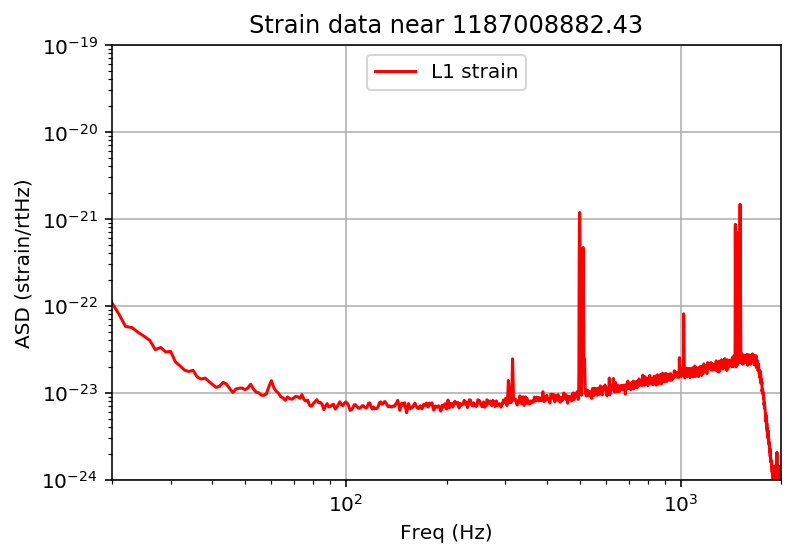

In [5]:
#-- How much data to use for the ASD?
deltat = 16  # Number of seconds on each side of data, best at around 16, below = loss of data, above = smudging affect
N_samp = deltat*fs

# -- Center the ASD segment on the requested time
indx1 = np.where(np.abs(rel_time) < dt) #You get the boundary where GW170817 occured
indx=indx1[0][0] #Take the lower bound

strain_seg = strain[indx-N_samp : indx+N_samp] #Take an interval of the strain data around the time of the event
time_seg = rel_time[indx-N_samp : indx+N_samp] #Take an interval of the time data around the time of the event

# number of sample for the fast fourier transform:
NFFT = fs #Sum over N terms in a DFT (disrete FT)
fmin = 20 
fmax = 2000
Pxx, freqs = mlab.psd(strain_seg, Fs = fs, NFFT=NFFT, 
                      noverlap=NFFT/2, window=np.blackman(NFFT)) #Its looking at a time series
# strain_seg is dicrete and filtered , this the FFT value x
# NFFT is the number of points per data block 
# Fs parameter scales the frequency axis on the interval [0,Fs/2]
# window takes samples along the frequencies




# We will use interpolations of the ASDs computed above for whitening:
psd = interp1d(freqs, Pxx) #Discrete to continuous

# plot the ASDs:
#fig1 = plt.figure()
detector = 'L1'
plt.loglog(freqs, np.sqrt(Pxx),'r',label='{0} strain'.format(detector))
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Strain data near {0}'.format(t0))
plt.savefig('asd.png')

http://faculty.jsd.claremont.edu/jmilton/Math_Lab_tool/Labs/Lab9.pdf

A good introduction to FFT and the psd command

In [109]:
print(N_samp)
?interpld


65536
Object `interpld` not found.


## Whiten the data

In [6]:
# function to writen data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht
# now whiten the data
strain_whiten = whiten(strain_seg,psd,dt)

## Band-pass the data

/home/calum/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


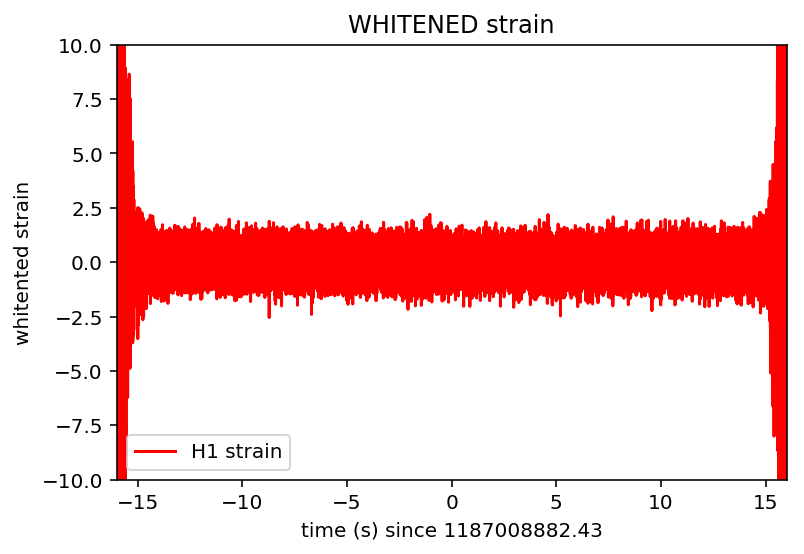

In [7]:
# We need to suppress the high frequencies with some bandpassing:
high_freq = 700.
low_freq  = 20.
bb, ab = butter(4, [low_freq*2./fs, high_freq*2./fs], btype='band')
strain_whitenbp = filtfilt(bb, ab, strain_whiten) #butterworth filter, how to damp the freuquencies not between 
# 

fig2 = plt.figure()
plt.plot(time_seg,strain_whitenbp,'r',label='H1 strain')

plt.xlim([-deltat,deltat])
plt.ylim([-10,10])
plt.xlabel('time (s) since '+str(t0))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('WHITENED strain')
plt.savefig('strain_whitened.png')

## Spectrogram

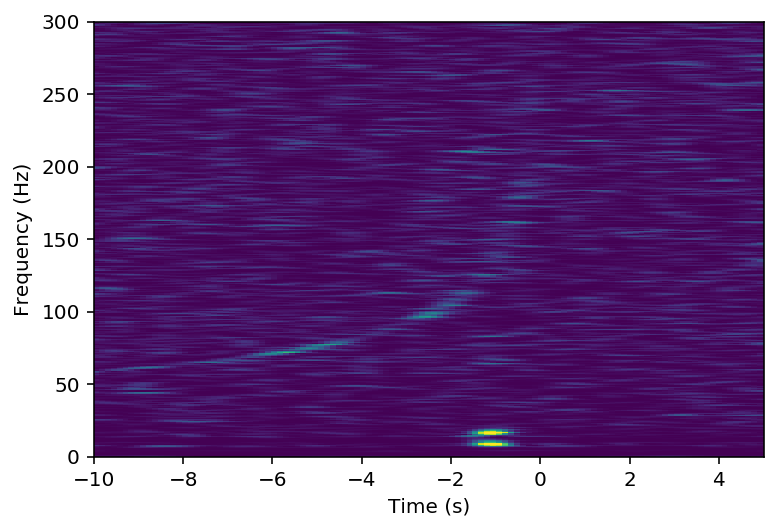

In [8]:
# pick a shorter FFT time interval:
NFFT = int(2*fs) # fs = 4096 
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15./16)
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT) 

spec_cmap='viridis' #just the type of spectromap
#spec_cmap='summer' 

# Calculate the whitened spectrogram
plt.figure()
spec_L1, freqs, bins, im = plt.specgram(strain_whiten, NFFT=NFFT, Fs=fs, window=window, 
      noverlap=NOVL, xextent=[-deltat,deltat], cmap=spec_cmap, vmin=0, vmax=0.01, scale='linear')
plt.axis([-10, 5, 0, 300])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.savefig("spectrogram.png")

/home/calum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


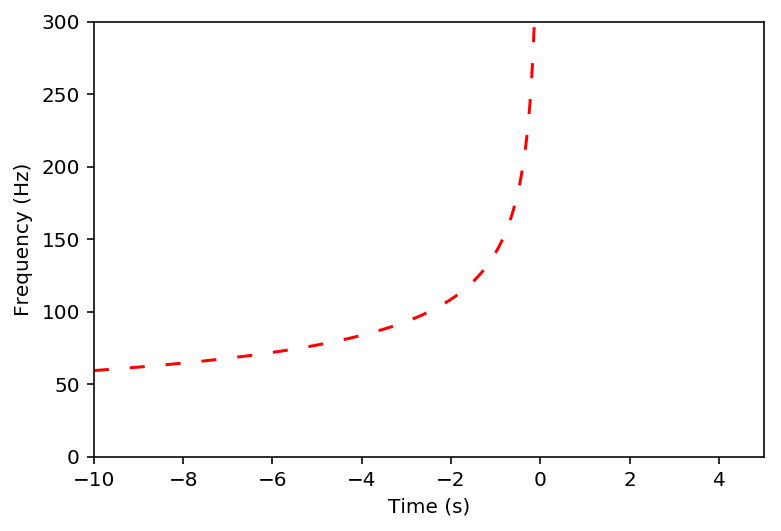

In [14]:

KK=0.0000007
tvalues=np.linspace(-10,5,500)
fvalues=(8/3.0*KK*(-tvalues))**(-3/8)
plt.plot(tvalues,fvalues,linestyle='--', dashes=(5,7), color='r')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(-10,5)
plt.ylim(0,300)
plt.savefig("chirpmass.png",transparent=True)

In [15]:
from PIL import Image

background=Image.open("spectrogram.png")
foreground=Image.open("chirpmass.png")
background.paste(foreground, (0,0), foreground)
background.show()
background.save('Image_paste.png')

Now that we have the k value, we can figure out the chirp mass as $k = (96/5)\pi^{8/3}\left(\frac{GM}{c^3}\right)^{5/3}$


In [8]:
#Should get around 4 solar masses
G = 6.67*10**(-11)
c = 3*10**8
#new variable const
const = (c**3)/G
M_chirp = ((5*KK)/(96*(np.pi**8/3)))**3/5
M_chirp*const

45.189867953023075

[0.0000e+00 5.0000e-01 1.0000e+00 ... 2.0470e+03 2.0475e+03 2.0480e+03]


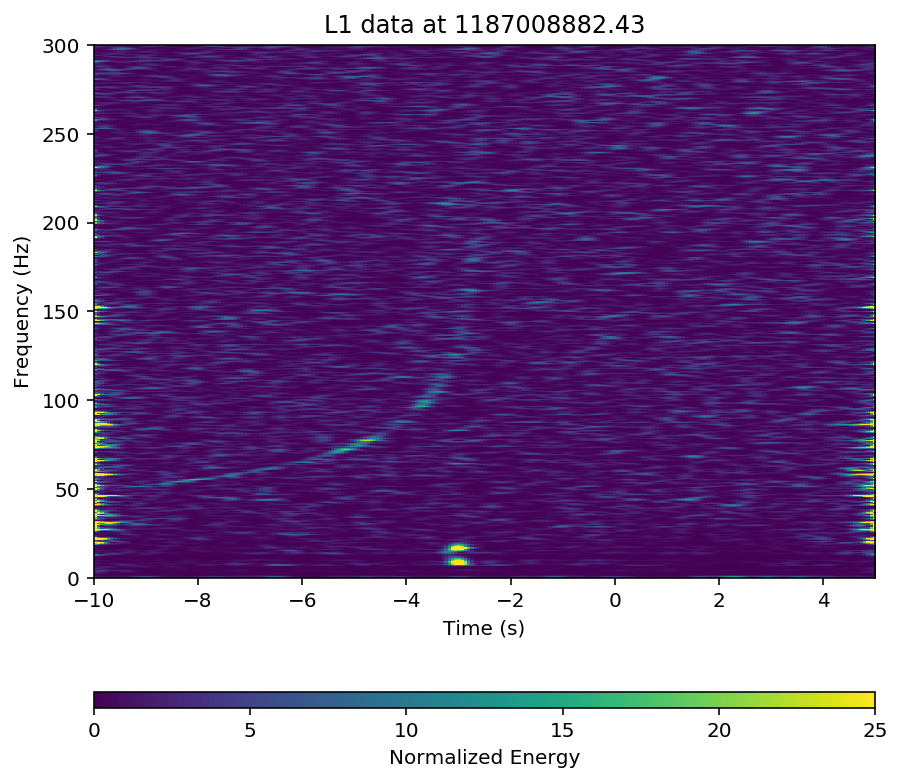

In [130]:
# -- Normalize the Spectrogram, and re-plot it with conventions that mimic Omega Pipeline
fig3, ax = plt.subplots(figsize=(7,7))
Z = np.flipud(spec_L1) / np.median(spec_L1)
extent = -10, 5, freqs[0], freqs[-1]
im = ax.imshow(Z,  cmap=spec_cmap, extent=extent, vmin=0, vmax=25)
ax.axis('auto')
fig3.colorbar(im, ax=ax, orientation='horizontal', label='Normalized Energy', aspect=50)
plt.axis([-10, 5, 0, 300])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('{ifo} data at {t0}'.format(ifo=detector, t0=t0))
print(freqs)

They have split the frequency data into sections the bottom bit has high NFFT I think, but the top bit has lower NFFT.

## Wavelets


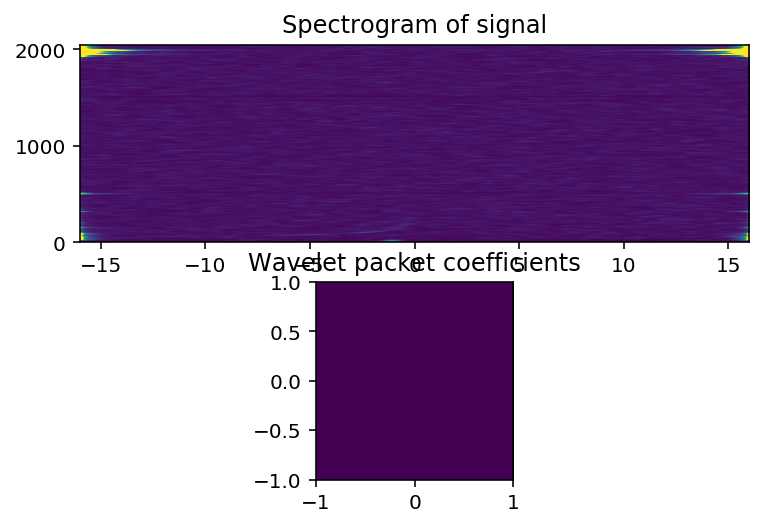

In [122]:
import pywt


wavelet = 'db2'
level = 4
order = "freq"  # other option is "normal"
interpolation = 'nearest'
cmap = plt.cm.cool

# Construct wavelet packet
wp = pywt.WaveletPacket(strain_whiten, wavelet, 'symmetric', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = np.array([n.data for n in nodes], 'd')
values = abs(values)

fig4 = plt.figure()
ax2 = fig4.add_subplot(211)
ax2.specgram(strain_whiten, NFFT=NFFT, noverlap=NOVL, Fs=fs, window=window,
             interpolation='bilinear', xextent=[-deltat,deltat], cmap=spec_cmap, vmin=0, vmax=0.01, scale='linear')
ax2.set_title("Spectrogram of signal")
ax3 = fig4.add_subplot(212)
ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
           interpolation='nearest')
ax3.set_title("Wavelet packet coefficients")


plt.show()

## PSD, Whitened Data, and Spectrogram

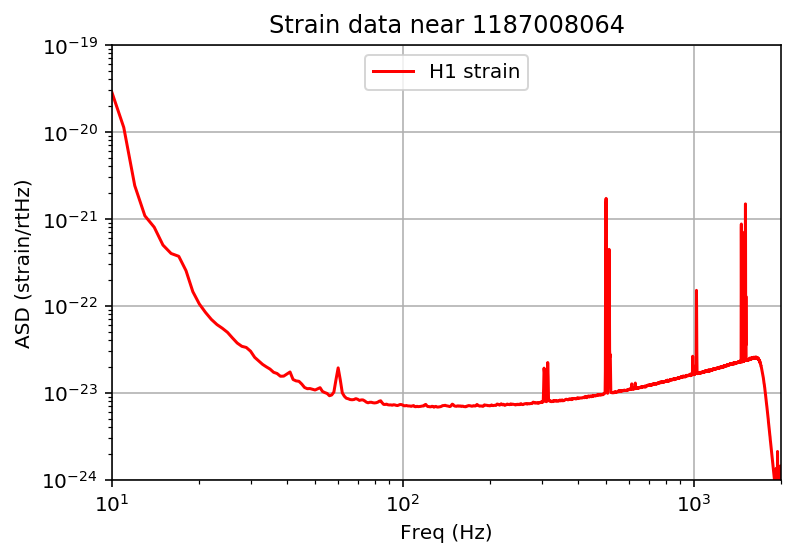

In [124]:
fig1

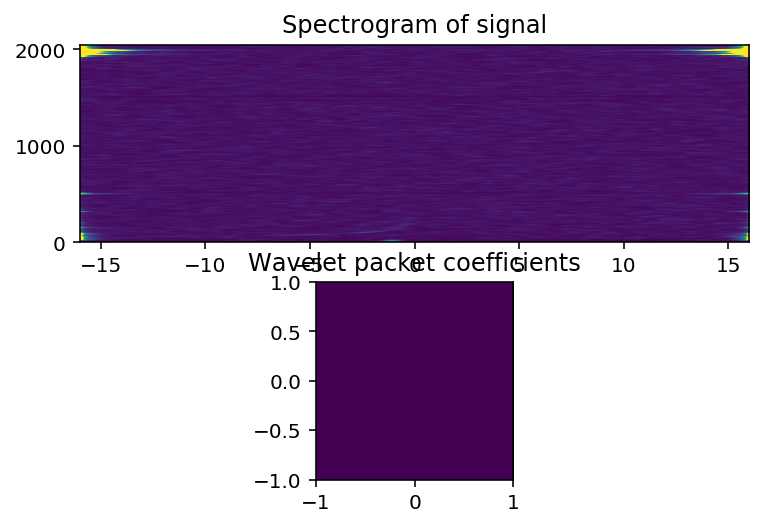

In [121]:
fig2

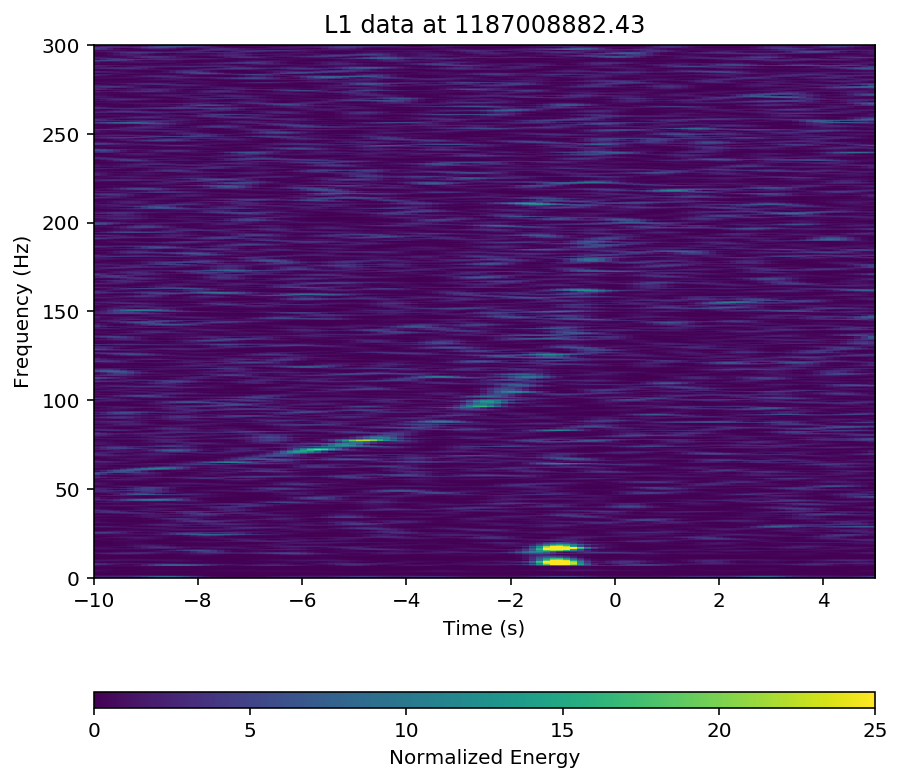

In [120]:
fig3

/home/calum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


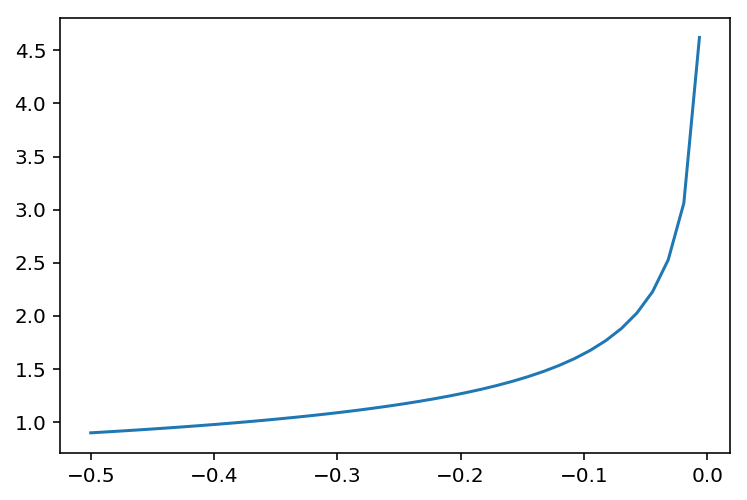

In [43]:
import numpy as np
ts = np.linspace(-0.5, 0.5, 80)
kappa = 1
t1 = 50
freq = ((8/3)*(-ts))**(-(3/8))
plt.plot(ts, freq)